In [1]:
import earthaccess
import rioxarray
import rasterio
import xarray as xr
import numpy as np
from timebudget import timebudget

In [2]:
results = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    #temporal=("2020-01-01", "2021-12-31"),
    temporal=("2019-01-01", "2019-01-31"),
)


Granules found: 31


In [3]:
@timebudget
def via_earthaccess():
  files = earthaccess.open(results)
  ds = xr.open_mfdataset(files,
                         decode_times=False, 
                         data_vars=['analysed_sst', 'sea_ice_fraction'], 
                         concat_dim="time", 
                         combine="nested",
                         parallel=True)
  return(ds)

ds2 = via_earthaccess()


Opening 31 granules, approx size: 11.63 GB


QUEUEING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/31 [00:00<?, ?it/s]

via_earthaccess took 78.229sec


In [4]:

dds = ds2.sel(lon=slice(-93, -76), lat=slice(41, 49))
cond = (dds.sea_ice_fraction < 0.15) | np.isnan(dds.sea_ice_fraction)
result = dds.analysed_sst.where(cond)

/opt/venv/lib/python3.10/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


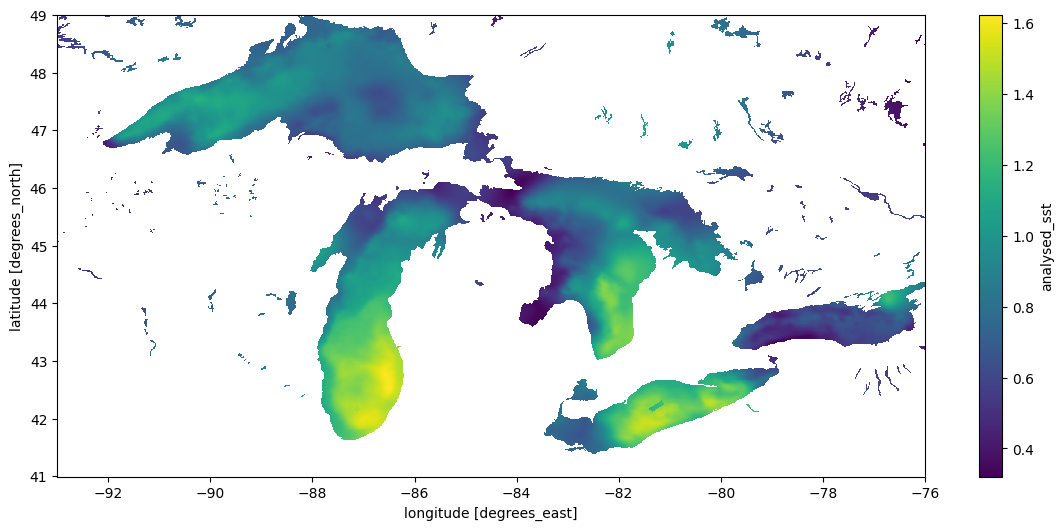

In [5]:
result.std("time").plot(figsize=(14, 6), x="lon", y="lat")

In [4]:

import os
from pathlib import Path
cookies = os.path.expanduser("~/.urs_cookies")
Path(cookies).touch()

@timebudget
def via_gdalvsi():
    ## pull out the URLs
    data_links = [granule.data_links(access="external") for granule in results]
    url_links = [f'{link[0]}' for link in data_links]
    # and here we go
    with rasterio.Env(GDAL_HTTP_COOKIEFILE=cookies, 
                    GDAL_HTTP_COOKIEJAR=cookies, 
                    GDAL_HTTP_NETRC=True):
        ds = xr.open_mfdataset(url_links, 
                               engine = "rasterio", 
                               decode_times=False,
                               data_vars=['analysed_sst', 'sea_ice_fraction'], 
                               concat_dim="time", 
                               combine="nested",
                               parallel=True)
    return(ds)

ds1 = via_gdalvsi()

/opt/venv/lib/python3.10/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [ ]:
dds = ds1.sel(x=slice(-93, -76)).where(ds1.y.isin([41,49])) # y is not integer indexed
cond = (dds.sea_ice_fraction < 0.15) | np.isnan(dds.sea_ice_fraction)
result = dds.analysed_sst.where(cond)

In [ ]:

result.std("time").plot(figsize=(14, 6), x="x", y="y")

: 